In [1]:
########## LIBRARIES ##########

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from scipy.linalg import hankel
import pysindy as ps
from scipy.interpolate import CubicSpline

# Ignore integration and solver convergence warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=ODEintWarning)


# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

seed = 10

# Seed the random number generators for reproducibility
np.random.seed(100)

In [2]:
########## PREPARE DATASET ##########

snowshoe_hare_pelts = np.array([20, 20, 52, 83, 64, 68, 83, 12, 36, 150, 110, 60, 7, 10, 70, 100, 92, 70, 10, 11, 137, 137, 18, 22, 52, 83, 18, 10, 9, 65])
canada_lynx_pelts   = np.array([32, 50, 12, 10, 13, 36, 15, 12, 6, 6, 65, 70, 40, 9, 20, 34, 45, 40, 15, 15, 60, 80, 26, 18, 37, 50, 35, 12, 12, 25])

x_test = np.stack((snowshoe_hare_pelts, canada_lynx_pelts)).T
m = x_test.shape[0]
n = x_test.shape[1]

t0 = 0.
T = 1.

t_test = np.linspace(t0, T, m, endpoint = True)
m_train = 25
t_train = np.linspace(t0, T*m_train/m, m_train ,endpoint = True)
x_train = x_test[:25,:]

dt = t_test[1] - t_test[0]
x0_train = np.array([20, 32])

m_spline = m*10

t_test_spline = np.linspace(t0, T, m_spline, endpoint = True )
t_train_spline = np.linspace(t0, T*m_train/m, m_train*10, endpoint = True)
dt_spline = t_test_spline[1] - t_test_spline[0]

cs = CubicSpline(t_test, x_test)
x_test_spline = cs(t_test_spline)

cs = CubicSpline(t_train, x_train)
x_train_spline = cs(t_train_spline)

Text(1894, 153, 'Test')

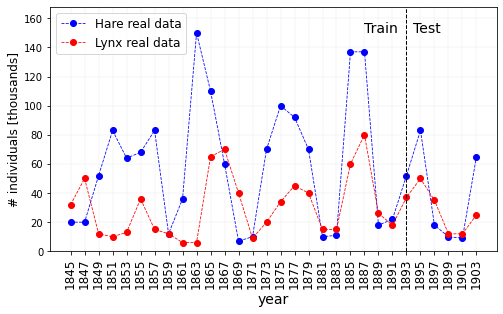

In [3]:
t0 = 1845
T = 1903

t_plot = t0 + t_test*(T-t0)

ax = plt.figure(figsize = [8,4.5])
plt.plot(t_plot, x_test[:,0], '.--', color = 'blue',linewidth = 0.8,markersize = 12, label = 'Hare real data')
plt.plot(t_plot, x_test[:,1], '.--', color = 'red',linewidth = 0.8,markersize = 12, label = 'Lynx real data')
plt.grid(True, linewidth = .1)
plt.xticks(t_plot, rotation = 90, fontsize = 12)
plt.axvline(x =  t_plot[m_train-1], color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel('year', fontsize = 14)
plt.ylim(0,168)
plt.ylabel('# individuals [thousands]',fontsize = 12)
plt.legend(loc = 'upper left',fontsize = 12)
plt.text(1887, 153, "Train", rotation=0, verticalalignment='center', fontsize = 14)
plt.text(1894, 153, "Test", rotation=0, verticalalignment='center', fontsize = 14)

In [4]:
'''plt.plot(np.concatenate((H[0,:], H[h-1,-h+1:])))
plt.plot(x_test[:,0])'''

'plt.plot(np.concatenate((H[0,:], H[h-1,-h+1:])))\nplt.plot(x_test[:,0])'

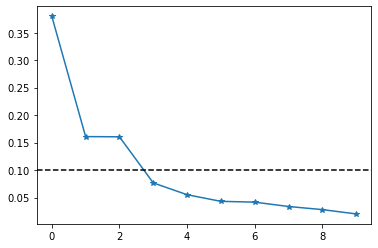

In [5]:
#### Time delay #####
h = 5

H1 = hankel(x_test[:h,0], x_test[h-1:,0])
H2 = hankel(x_test[:h,1], x_test[h-1:,1])
H = np.concatenate((H1, H2))

U,S,V = np.linalg.svd(H, full_matrices = False)

plt.plot(S / np.sum(S),'*-')
plt.axhline(y = 0.1, linestyle = '--', color = 'black')

idx_energy = 3

U = U[:,:idx_energy]

m_train_H = 20
t_train_H = t_test[:m_train_H]

dt_H = t_test[1] - t_test[0]
t_train_span_H = (t_train_H[0], t_train_H[-1])
x_train_H = np.matmul(np.transpose(H[:,:m_train_H]), U / S[:idx_energy]) #V[:idx_energy,:m_train].T
x0_train_H = x_train_H[0,:]#np.array([-0.15206082,  0.13337764, -0.0250638 ])

In [6]:
t_train_spline_H = np.linspace(t_train_H[0], t_train_H[-1], len(t_train_H)*10, endpoint = True)

dt_spline_H = t_train_spline_H[1] - t_train_spline_H[0]

cs = CubicSpline(t_train_H, x_train_H)
x_train_spline_H = cs(t_train_spline_H)

In [7]:
rescale = True

In [8]:
rescale = True
if rescale:
    mean = x_train_spline_H.mean(axis = 0)
else:
    mean = 0.

x_train_spline_H = (x_train_spline_H - mean)
x_train_H = (x_train_H - mean) 
x0_train_H = (x0_train_H - mean)

In [9]:
tot_comb =  500
p = 110

#feature_names = ['x', 'y', 'dx', 'dy']
ensemble_optimizer = ps.STLSQ(threshold = 1.) 
new_library = ps.PolynomialLibrary(degree = 4, include_interaction = True, include_bias = True) #+ custom_library
model = ps.SINDy(optimizer=ensemble_optimizer, feature_library = new_library)
list_coef = []
mse_coef = []
std_coef = []

k = 1
np.random.seed(seed)

for j in range(tot_comb):
        ind  = list(np.sort(np.random.permutation(range(x_train_spline_H.shape[0]))[:p]))
        
        xdata_cycle = x_train_spline_H[ind,:] 
        ts_ind = t_train_spline_H[ind]

        model.fit(xdata_cycle, t = ts_ind, unbias = False)#, ensemble_aggregator= ensemble_aggregator)ù
        
        x0_train_test = x0_train_H

        pred = model.simulate(x0_train_test, t_train_spline_H) 
        mse = np.mean(np.square(pred - x_train_spline_H))
        std = np.square(pred - x_train_spline_H).std(axis = 0)
        
        if mse < 2e-2:
            k = k+1
            mse_coef.append(mse)
            list_coef.append(model.coefficients())
            std_coef.append(std)
            print(j, 'mse < 2e-2')        
        '''
        if k%10 == 0:
            k = k+1
            model.print()
            print('\n')
            print('MSE:', mse, '\n\n')
            plt.figure(figsize = [18,5] )
            for i in range(idx_energy):
                plt.subplot(1,idx_energy,int(i+1))
                plt.plot(t_train_spline_H, pred[:,i], '--')
                plt.plot(t_train_spline_H, x_train_spline_H[:,i])
            plt.show()
        '''


1 mse < 2e-2
2 mse < 2e-2
6 mse < 2e-2
8 mse < 2e-2
10 mse < 2e-2
12 mse < 2e-2
16 mse < 2e-2
18 mse < 2e-2
22 mse < 2e-2
25 mse < 2e-2
30 mse < 2e-2
36 mse < 2e-2
37 mse < 2e-2
38 mse < 2e-2
40 mse < 2e-2
41 mse < 2e-2
42 mse < 2e-2
43 mse < 2e-2
53 mse < 2e-2
57 mse < 2e-2
58 mse < 2e-2
59 mse < 2e-2
61 mse < 2e-2
67 mse < 2e-2
68 mse < 2e-2
70 mse < 2e-2
72 mse < 2e-2
74 mse < 2e-2
75 mse < 2e-2
76 mse < 2e-2
81 mse < 2e-2
83 mse < 2e-2
84 mse < 2e-2
88 mse < 2e-2
89 mse < 2e-2
98 mse < 2e-2
107 mse < 2e-2
108 mse < 2e-2
111 mse < 2e-2
113 mse < 2e-2
126 mse < 2e-2
128 mse < 2e-2
133 mse < 2e-2
136 mse < 2e-2
137 mse < 2e-2
142 mse < 2e-2
148 mse < 2e-2
150 mse < 2e-2
151 mse < 2e-2
153 mse < 2e-2
160 mse < 2e-2
162 mse < 2e-2
166 mse < 2e-2
168 mse < 2e-2
174 mse < 2e-2
175 mse < 2e-2
176 mse < 2e-2
178 mse < 2e-2
179 mse < 2e-2
190 mse < 2e-2
192 mse < 2e-2
195 mse < 2e-2
196 mse < 2e-2
198 mse < 2e-2
199 mse < 2e-2
207 mse < 2e-2
212 mse < 2e-2
217 mse < 2e-2
218 mse < 2e-2
219 m

In [10]:
coef_final = np.mean(np.asarray(list_coef), axis = 0)
ensemble_optimizer.coef_ = coef_final
model.print()

x0' = -0.223 x0 + -0.657 x1 + 0.439 x2 + -0.412 x0 x1 + 2.965 x1^2 + 0.197 x1 x2 + -1.952 x2^2 + -0.155 x1^3 + -0.125 x1^2 x2 + 1.070 x1 x2^2 + 0.071 x2^3 + 0.264 x1^4 + 0.019 x1 x2^3 + -0.079 x2^4
x1' = -0.781 1 + 9.988 x0 + -0.678 x1 + -32.466 x2 + -1.510 x0 x1 + 1.732 x0 x2 + 5.705 x1^2 + 4.930 x1 x2 + 7.109 x2^2 + 0.035 x0 x2^2 + 0.941 x1^3 + 0.065 x1^2 x2 + 0.023 x1 x2^2 + 0.526 x2^3 + 0.025 x1^4 + 0.499 x1^3 x2 + 0.329 x1^2 x2^2 + 0.260 x1 x2^3 + 1.593 x2^4
x2' = -4.321 x0 + 32.387 x1 + 4.056 x2 + -3.889 x0 x1 + -0.124 x0 x2 + 22.475 x1^2 + 0.370 x1 x2 + -5.383 x2^2 + -0.626 x0 x1^2 + 1.101 x0 x2^2 + 6.855 x1^3 + -1.963 x1^2 x2 + 7.811 x1 x2^2 + -6.174 x2^3 + 3.812 x1^4 + 0.691 x1^3 x2 + 1.133 x1^2 x2^2 + 2.241 x1 x2^3 + -3.587 x2^4


In [11]:
#### Time delay #####
m_test_H = 26
t_test_H = t_test[:m_test_H]

dt_H = t_test[1] - t_test[0]
t_test_span_H = (t_test_H[0], t_test_H[-1])
x_test_H = np.matmul(np.transpose(H[:,:m_test_H]), U / S[:idx_energy]) #V[:idx_energy,:m_test_H].T
x0_test_H = x_test_H[0,:]#np.array([-0.15206082,  0.13337764, -0.0250638 ])

In [20]:
x_rec = np.matmul(x_test_H * S[:idx_energy], U.T ).T
x_rec = np.concatenate((x_rec[0,:], x_rec[h-1,-h+1:]))

'''
plt.figure()
plt.plot(x_rec)
plt.plot(x_test[:,0],'--')
'''

"\nplt.figure()\nplt.plot(x_rec)\nplt.plot(x_test[:,0],'--')\n"

In [13]:
t_test_spline_H = np.linspace(t_test_H[0], t_test_H[-1], len(t_test_H)*10, endpoint = True)

dt_spline_H = t_test_spline_H[1] - t_test_spline_H[0]

cs = CubicSpline(t_test_H, x_test_H)
x_test_spline_H = cs(t_test_spline_H)

In [14]:
coef_final = np.mean(np.asarray(list_coef), axis = 0)
ensemble_optimizer.coef_ = coef_final
model.print()

pred = model.simulate(x0_train_H, t_test_spline_H)
pred = pred[::10,:]

'''
for i in range(idx_energy):
    plt.figure()
    plt.plot(t_test_H, pred[:,i],'*-')
    plt.plot(t_test_H, x_test_H[:,i])
'''

x0' = -0.223 x0 + -0.657 x1 + 0.439 x2 + -0.412 x0 x1 + 2.965 x1^2 + 0.197 x1 x2 + -1.952 x2^2 + -0.155 x1^3 + -0.125 x1^2 x2 + 1.070 x1 x2^2 + 0.071 x2^3 + 0.264 x1^4 + 0.019 x1 x2^3 + -0.079 x2^4
x1' = -0.781 1 + 9.988 x0 + -0.678 x1 + -32.466 x2 + -1.510 x0 x1 + 1.732 x0 x2 + 5.705 x1^2 + 4.930 x1 x2 + 7.109 x2^2 + 0.035 x0 x2^2 + 0.941 x1^3 + 0.065 x1^2 x2 + 0.023 x1 x2^2 + 0.526 x2^3 + 0.025 x1^4 + 0.499 x1^3 x2 + 0.329 x1^2 x2^2 + 0.260 x1 x2^3 + 1.593 x2^4
x2' = -4.321 x0 + 32.387 x1 + 4.056 x2 + -3.889 x0 x1 + -0.124 x0 x2 + 22.475 x1^2 + 0.370 x1 x2 + -5.383 x2^2 + -0.626 x0 x1^2 + 1.101 x0 x2^2 + 6.855 x1^3 + -1.963 x1^2 x2 + 7.811 x1 x2^2 + -6.174 x2^3 + 3.812 x1^4 + 0.691 x1^3 x2 + 1.133 x1^2 x2^2 + 2.241 x1 x2^3 + -3.587 x2^4


"\nfor i in range(idx_energy):\n    plt.figure()\n    plt.plot(t_test_H, pred[:,i],'*-')\n    plt.plot(t_test_H, x_test_H[:,i])\n"

### Plots

In [15]:
x_reconstruct = np.matmul((pred + mean)* (S[:idx_energy])  , U[:,:idx_energy].T)
x1_reconstruct = np.concatenate((x_reconstruct[:,0], x_reconstruct[-h+1:, h-1]))
x2_reconstruct = np.concatenate((x_reconstruct[:,h], x_reconstruct[-h+1:, -1]))

x_reconstruct = np.stack((x1_reconstruct, x2_reconstruct))

In [16]:
t0 = 1845
T = 1903

t_plot = t0 + t_test*(T-t0)

In [17]:
list_1 = []
list_2 = []
for i in range(len(list_coef)):
    if i%10==0:
        print(i)
    coef_final = list_coef[i]
    ensemble_optimizer.coef_ = coef_final

    pred = model.simulate(x0_train_H, t_test_H)
    x_reconstruct = np.matmul((pred + mean)* (S[:idx_energy])  , U[:,:idx_energy].T)

    x1_reconstruct = np.concatenate((x_reconstruct[:,0], x_reconstruct[-h+1:, h-1]))
    x2_reconstruct = np.concatenate((x_reconstruct[:,h], x_reconstruct[-h+1:, -1]))
    x_reconstruct = np.stack((x1_reconstruct, x2_reconstruct))
    
    list_1.append(x_reconstruct[0,:])
    list_2.append(x_reconstruct[1,:])


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170


In [18]:
std_1 = np.asarray(list_1).std(axis = 0)
std_2 = np.asarray(list_2).std(axis = 0)

mean_1 = np.asarray(list_1).mean(axis = 0)
mean_2 = np.asarray(list_2).mean(axis = 0)

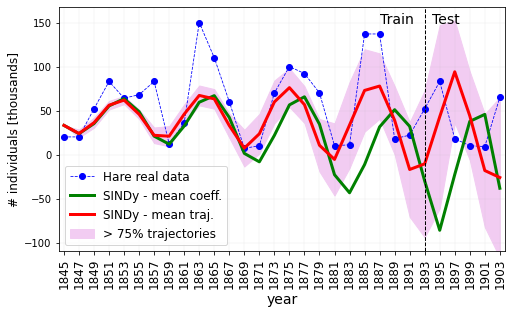

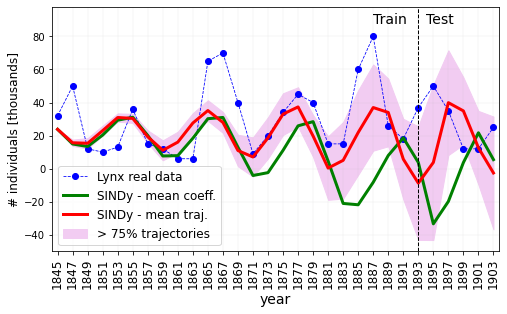

In [19]:
ax = plt.figure(figsize = [8,4.5])
plt.plot(t_plot, x_test[:,0], '.--', color = 'blue',linewidth = 0.8,markersize = 12, label = 'Hare real data')
plt.plot(t_plot, x1_reconstruct, '-', color = 'green', linewidth = 3, markersize = 6,  label = 'SINDy - mean coeff.')
plt.plot(t_plot, mean_1, '-', color = 'red', linewidth = 3, markersize = 6,  label = 'SINDy - mean traj.')
plt.fill_between(t_plot, mean_1 - 2*std_1, mean_1 + 2*std_1, color = [0.95, 0.8, 0.95], label = '> 75% trajectories')
plt.grid(True, linewidth = .1)
plt.xticks(t_plot, rotation = 90, fontsize = 12)
plt.axvline(x =  t_plot[m_train-1], color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel('year', fontsize = 14)
plt.ylim(-110,168)
plt.xlim(t_plot[0]-0.7,t_plot[-1]+0.7)
plt.ylabel('# individuals [thousands]',fontsize = 12)
plt.legend(loc = 'lower left',fontsize = 12)
plt.text(1887, 153, "Train", rotation=0, verticalalignment='center', fontsize = 14)
plt.text(1894, 153, "Test", rotation=0, verticalalignment='center', fontsize = 14)
plt.savefig('hare_sindy_full.pdf', dpi=300, transparent=True, bbox_inches='tight', pad_inches = 0)

plt.figure(figsize = [8,4.5])
plt.plot(t_plot, x_test[:,1], '.--', color = 'blue',linewidth = 0.8,markersize = 12, label = 'Lynx real data')
plt.plot(t_plot, x2_reconstruct, '-', color = 'green', linewidth = 3, markersize = 6,  label = 'SINDy - mean coeff.')
plt.plot(t_plot, mean_2, '-', color = 'red', linewidth = 3, markersize = 6,  label = 'SINDy - mean traj.')
plt.fill_between(t_plot, mean_2 - 2*std_2, mean_2 + 2*std_2, color = [0.95, 0.8, 0.95], label = '> 75% trajectories')
plt.grid(True, linewidth = .1)
plt.xticks(t_plot, rotation = 90, fontsize = 12)
plt.axvline(x =  t_plot[m_train-1], color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel('year', fontsize = 14)
plt.ylim(-50,98)
plt.xlim(t_plot[0]-0.7,t_plot[-1]+0.7)
plt.ylabel('# individuals [thousands]',fontsize = 12)
plt.legend(loc = 'lower left',fontsize = 12)
plt.text(1887, 90, "Train", rotation=0, verticalalignment='center', fontsize = 14)
plt.text(1894, 90, "Test", rotation=0, verticalalignment='center', fontsize = 14)
plt.savefig('lynx_sindy_full.pdf', dpi=300, transparent=True, bbox_inches='tight', pad_inches = 0)
